## Importing the relevant libraries

In [104]:
!pip install torchinfo

In [175]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings, torch, time
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

## Loading the dataset

In [106]:
df = pd.read_csv('/kaggle/input/pbd-load-history/PDB_Load_History.csv')
df.head()

,date,year,month,day,weekday,hour,demand,temperature
0,3/1/2003,2003,3,1,7,1,12863.0,29
1,3/1/2003,2003,3,1,7,2,12389.0,28
2,3/1/2003,2003,3,1,7,3,12155.0,29
3,3/1/2003,2003,3,1,7,4,12072.0,27
4,3/1/2003,2003,3,1,7,5,12160.0,29


## Data Exploration

In [107]:
df.shape

(103776, 8)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103776 entries, 0 to 103775
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         103776 non-null  object 
 1   year         103776 non-null  int64  
 2   month        103776 non-null  int64  
 3   day          103776 non-null  int64  
 4   weekday      103776 non-null  int64  
 5   hour         103776 non-null  int64  
 6   demand       103776 non-null  float64
 7   temperature  103776 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 6.3+ MB


In [109]:
df.describe()

,year,month,day,weekday,hour,demand,temperature
count,103776.000000,103776.000000,103776.000000,103776.000000,103776.00000,103776.000000,103776.000000
mean,2008.574699,6.591813,15.735661,3.999306,12.50000,14674.947493,50.576097
std,3.414726,3.420534,8.802989,2.000183,6.92222,2894.544130,18.300454
min,2003.000000,1.000000,1.000000,1.000000,1.00000,7794.000000,-7.000000
25%,2006.000000,4.000000,8.000000,2.000000,6.75000,12514.000000,36.000000
50%,2009.000000,7.000000,16.000000,4.000000,12.50000,14773.000000,51.000000
75%,2012.000000,10.000000,23.000000,6.000000,18.25000,16443.000000,65.000000
max,2014.000000,12.000000,31.000000,7.000000,24.00000,27622.000000,100.000000


## Data Preprocessing

In [110]:
df = df.groupby(['date','hour']).agg({'demand': 'sum'}).reset_index()
df.head()

,date,hour,demand
0,1/1/2004,1,12094.0
1,1/1/2004,2,11390.0
2,1/1/2004,3,10883.0
3,1/1/2004,4,10644.0
4,1/1/2004,5,10633.0


In [111]:
df['datetime'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour']-1,unit='h') # Combine date and hour into a single datetime column
df.drop('hour',axis=1,inplace=True)
df.head()

,date,demand,datetime
0,1/1/2004,12094.0,2004-01-01 00:00:00
1,1/1/2004,11390.0,2004-01-01 01:00:00
2,1/1/2004,10883.0,2004-01-01 02:00:00
3,1/1/2004,10644.0,2004-01-01 03:00:00
4,1/1/2004,10633.0,2004-01-01 04:00:00


In [112]:
df['date'] = df['datetime'].dt.date
df = df.groupby('date')['demand'].mean().reset_index() # Group by each day to compute average demand
df.head()

,date,demand
0,2003-03-01,14216.875
1,2003-03-02,13851.625
2,2003-03-03,16348.875
3,2003-03-04,16575.500
4,2003-03-05,15391.875


In [113]:
df.shape

(4324, 2)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    4324 non-null   object 
 1   demand  4324 non-null   float64
dtypes: float64(1), object(1)
memory usage: 67.7+ KB


In [115]:
df.date = pd.to_datetime(df.date) # Convert date to pandas datetime object

In [116]:
df = df.set_index('date') # Set date as dataframe index
df.head()

,demand
date,
2003-03-01,14216.875
2003-03-02,13851.625
2003-03-03,16348.875
2003-03-04,16575.500
2003-03-05,15391.875


In [117]:
df = df.resample('MS').agg({'demand': 'mean'}) # Resample the dataset to "Monthly Start" frequency
df.head()

,demand
date,
2003-03-01,14401.322581
2003-04-01,13633.978472
2003-05-01,12926.286290
2003-06-01,14308.227778
2003-07-01,16243.716398


In [118]:
df.shape

(142, 1)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142 entries, 2003-03-01 to 2014-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  142 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [120]:
df.index

DatetimeIndex(['2003-03-01', '2003-04-01', '2003-05-01', '2003-06-01',
               '2003-07-01', '2003-08-01', '2003-09-01', '2003-10-01',
               '2003-11-01', '2003-12-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', name='date', length=142, freq='MS')

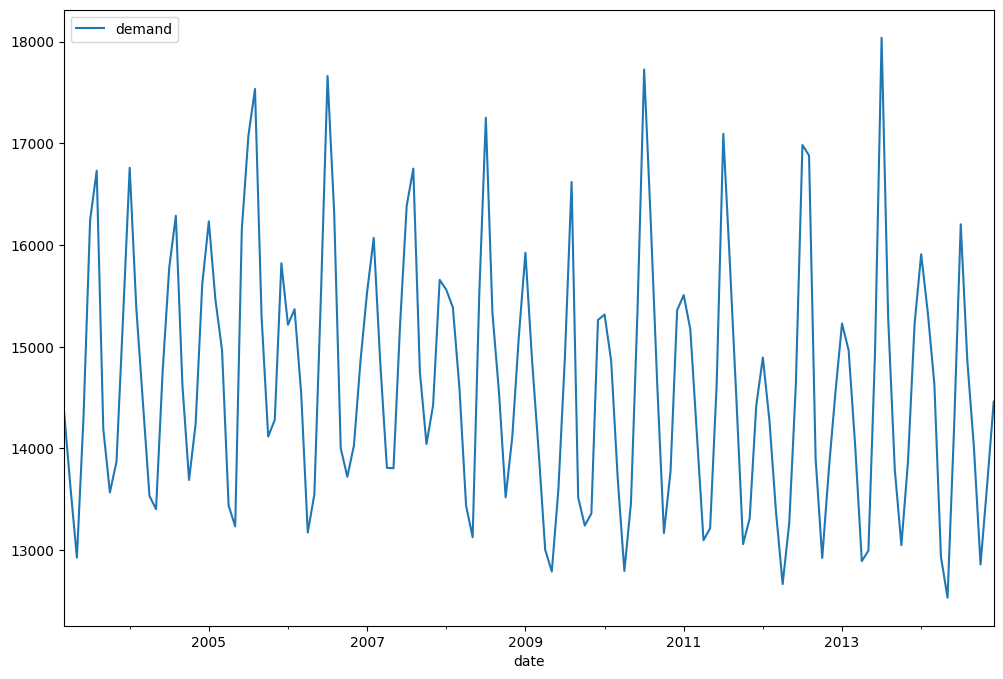

In [121]:
df.plot(figsize=(12,8));

In [122]:
y = df.demand.astype('float').values
y

array([14401.32258065, 13633.97847222, 12926.28629032, 14308.22777778,
       16243.71639785, 16731.09543011, 14191.38611111, 13567.76747312,
       13869.62222222, 15294.30913978, 16759.68951613, 15385.01149425,
       14453.94758065, 13533.13194444, 13402.98521505, 14758.81805556,
       15779.56048387, 16287.77419355, 14619.80833333, 13690.27822581,
       14242.50972222, 15612.47177419, 16233.05645161, 15462.8735119 ,
       14969.18413978, 13438.56666667, 13233.79301075, 16151.76388889,
       17075.41532258, 17534.68413978, 15291.9875    , 14116.54032258,
       14281.85      , 15820.30241935, 15215.62365591, 15369.54166667,
       14543.40994624, 13173.69166667, 13548.51747312, 15512.68611111,
       17662.9233871 , 16322.94489247, 14000.95972222, 13720.95026882,
       14029.0375    , 14865.20833333, 15539.59274194, 16070.59375   ,
       14833.25537634, 13809.01944444, 13805.47043011, 15222.15277778,
       16386.49327957, 16751.33064516, 14751.52777778, 14043.68413978,
      

## Splitting dataset into train and test sets

In [123]:
test_size = 12
train_df = df[:-test_size]
test_df = df[-test_size:]

## Scaling train data using MinMaxScaler

In [124]:
scaler = MinMaxScaler(feature_range=(0,1))
train_norm = scaler.fit_transform(train_df)

In [125]:
train_norm = torch.FloatTensor(train_norm).view(-1) # Convert train data to tensors

## Creating batches of time series data

In [126]:
def input_data(sequences,window_size):
    """
    Custom function to create batches of time series data
    args**: sequences: input time series sequence, window_size: length of each window
    """
    output_sequences = []

    for i in range(len(sequences)-window_size):
        window = sequences[i:i+window_size]
        label = sequences[i+window_size:i+window_size+1]
        output_sequences.append((window,label))

    return output_sequences

In [127]:
train_data = input_data(train_norm,window_size=10) # Create batches of train data
train_data[0]

(tensor([0.3229, 0.1800, 0.0483, 0.3056, 0.6659, 0.7566, 0.2838, 0.1677, 0.2239,
         0.4891]),
 tensor([0.7619]))

In [128]:
len(train_data)

120

## Define LSTM model architecture

In [129]:
class LSTM(nn.Module):

    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size)
        self.linear = nn.Linear(in_features=hidden_size,out_features=output_size)
        self.hidden = (torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))

    def forward(self,sequence):
        lstm_output, self.hidden = self.lstm(sequence.view(len(sequence),1,-1),self.hidden)
        pred = self.linear(lstm_output.view(len(lstm_output),-1))
        return pred[-1]

In [130]:
torch.manual_seed(42)
model = LSTM(hidden_size=150)
model

LSTM(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

In [131]:
summary(model)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              91,800
├─Linear: 1-2                            151
Total params: 91,951
Trainable params: 91,951
Non-trainable params: 0

In [132]:
total_params = 0

for param in model.parameters():
    print(param.numel())
    total_params += param.numel()

print("Total LSTM model parameters:", total_params)

600
90000
600
600
150
1
Total LSTM model parameters: 91951


In [133]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(params=model.parameters(),lr=0.001)

## Model Training & Evaluation

In [134]:
epochs = 100

losses = []
start_time = time.time()

for i in range(1,epochs+1):

    for seq, y_train in train_data:
        optimizer.zero_grad() # Reset optimizer gradients to zero at each step to prevent them from accumulating during multiple iterations
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size)) # Reset model hidden state to zero at each step
        y_pred = model(seq) # Make prediction
        loss = criterion(y_pred,y_train) # Get the MSE Loss
        loss.backward() # Backpropagate the gradients
        optimizer.step() # Optimize model by updating parameters

    losses.append(loss.item())
    print(f"Epoch {i} -> Loss: {loss.item()}")

print(f"Total time elapsed in LSTM model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.02513434924185276
Epoch 2 -> Loss: 0.00789650809019804
Epoch 3 -> Loss: 0.002560440683737397
Epoch 4 -> Loss: 0.0028657361399382353
Epoch 5 -> Loss: 0.004088916815817356
Epoch 6 -> Loss: 0.005321107804775238
Epoch 7 -> Loss: 0.006389382760971785
Epoch 8 -> Loss: 0.007217332720756531
Epoch 9 -> Loss: 0.007809245493263006
Epoch 10 -> Loss: 0.008155477233231068
Epoch 11 -> Loss: 0.008208567276597023
Epoch 12 -> Loss: 0.007958733476698399
Epoch 13 -> Loss: 0.007461798842996359
Epoch 14 -> Loss: 0.006593227852135897
Epoch 15 -> Loss: 0.005336075089871883
Epoch 16 -> Loss: 0.004250931087881327
Epoch 17 -> Loss: 0.00387955573387444
Epoch 18 -> Loss: 0.003901304444298148
Epoch 19 -> Loss: 0.0037975492887198925
Epoch 20 -> Loss: 0.003470414085313678
Epoch 21 -> Loss: 0.003070584964007139
Epoch 22 -> Loss: 0.0027122898027300835
Epoch 23 -> Loss: 0.00238260580226779
Epoch 24 -> Loss: 0.002171702915802598
Epoch 25 -> Loss: 0.002121591940522194
Epoch 26 -> Loss: 0.002048730384558

## Visualizing model performance

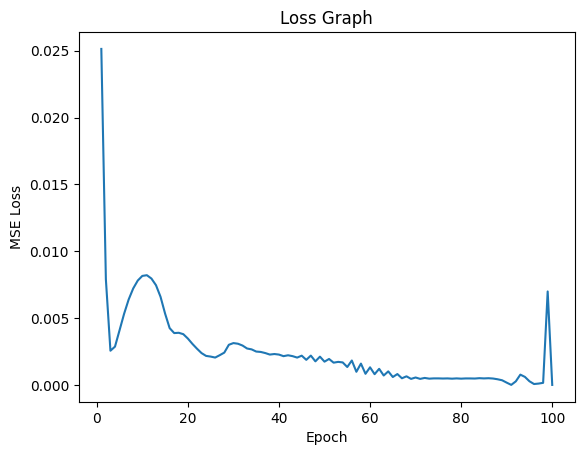

In [135]:
plt.plot(range(1,epochs+1),losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Graph')
plt.show()

## Evaluating model on test data

In [136]:
window_size = 12
predictions = train_norm[-window_size:].tolist()

model.eval() # Set model to evaluation phase

for i in range(test_size):
    sequence = torch.FloatTensor(predictions[-window_size:]) # Convert each sequence to tensors

    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size)) # Reset model hidden states to zero
        predictions.append(model(sequence).item()) # Get prediction

In [137]:
predictions

[0.47693607211112976,
 0.428013414144516,
 0.25213268399238586,
 0.041941624134778976,
 0.06111649423837662,
 0.42200595140457153,
 1.0,
 0.486234188079834,
 0.20963984727859497,
 0.07112447917461395,
 0.22391153872013092,
 0.4756264388561249,
 0.45567604899406433,
 0.3580300509929657,
 0.423644095659256,
 0.4670713245868683,
 0.44819217920303345,
 0.4624095857143402,
 0.4843340814113617,
 0.47235459089279175,
 0.45107999444007874,
 0.35142800211906433,
 0.1976366490125656,
 0.20878006517887115]

In [138]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1)) # Get true predictions using inverse scaling operation
true_predictions[-12:]

array([[15114.62240323],
       [14590.10200683],
       [14942.55787213],
       [15175.83386703],
       [15074.42165328],
       [15150.79262446],
       [15268.56340267],
       [15204.21373915],
       [15089.93399402],
       [14554.63809266],
       [13728.52434355],
       [13788.38290595]])

## Visualizing model performance on test data

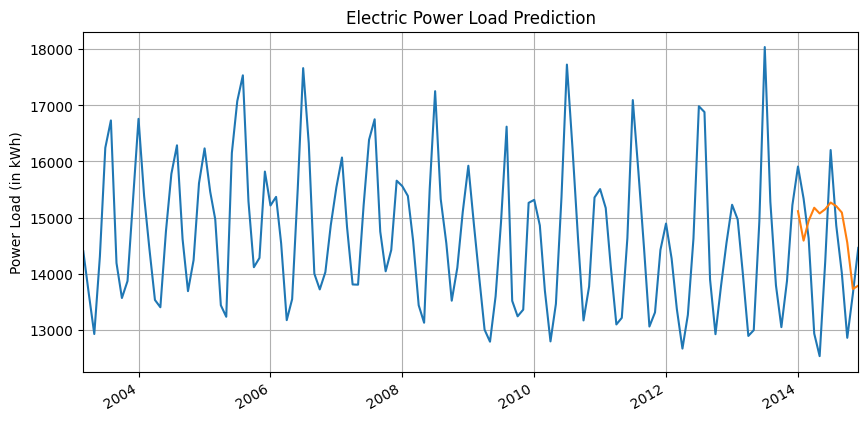

In [141]:
fig = plt.figure(figsize=(10,5))
plt.title('Electric Power Load Prediction')
plt.ylabel('Power Load (in kWh)')
plt.grid(visible=True)
plt.autoscale(enable=True,axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['demand'])
plt.plot(test_df.index,true_predictions[-12:])
plt.show()

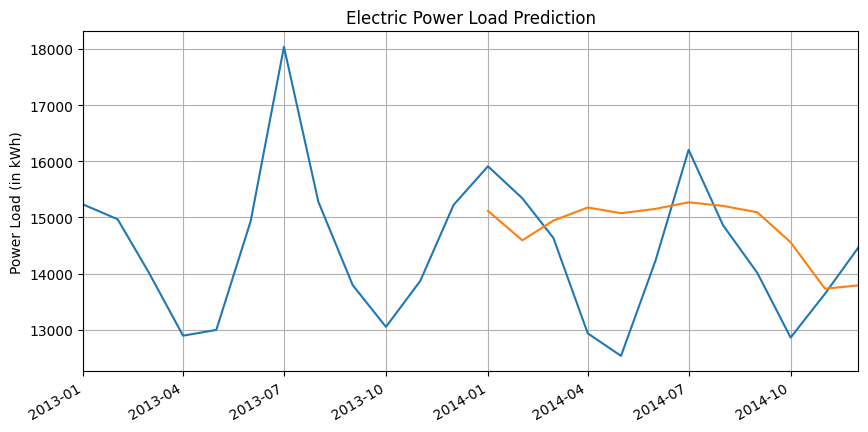

In [142]:
fig = plt.figure(figsize=(10,5))
plt.title('Electric Power Load Prediction')
plt.ylabel('Power Load (in kWh)')
plt.grid(visible=True)
plt.autoscale(enable=True,axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['demand']['2013-01-01':])
plt.plot(test_df.index,true_predictions[-12:])
plt.show()

In [179]:
print("MAE:", mean_absolute_error(test_df.demand.values,true_predictions[-test_size:]))
print("MAPE:", mean_absolute_percentage_error(test_df.demand.values,true_predictions[-test_size:]))
print("MSE:", mean_squared_error(test_df.demand.values,true_predictions[-test_size:]))
print("RMSE:", np.sqrt(mean_squared_error(test_df.demand.values,true_predictions[-test_size:])))
print("MSLE:", mean_squared_log_error(test_df.demand.values,true_predictions[-test_size:]))

MAE: 1145.5327566223377
MAPE: 0.0820635523244653
MSE: 1758977.7073169483
RMSE: 1326.2645691252362
MSLE: 0.008430462926301093


## Re-training the model on the whole dataset

In [143]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(params=model.parameters(),lr=0.001)

In [146]:
y.shape

(142,)

In [148]:
epochs = 100
y_norm = scaler.transform(y.reshape(-1,1)) # Scale whole data
y_norm = torch.FloatTensor(y_norm).view(-1) # Convert data to tensors
all_data = input_data(y_norm,window_size=10) # Create batches of complete dataset

losses = []
model.train() # Set model back to training mode

start_time = time.time()

for i in range(1,epochs+1):
    
    for seq, y_train in all_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    print(f"Epoch {i} -> Loss: {loss.item()}")

print(f"Total time elapsed in LSTM model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.014017636887729168
Epoch 2 -> Loss: 0.0009713429026305676
Epoch 3 -> Loss: 0.003210358554497361
Epoch 4 -> Loss: 0.0070135449059307575
Epoch 5 -> Loss: 0.001693185418844223
Epoch 6 -> Loss: 0.003985519986599684
Epoch 7 -> Loss: 0.0037525338120758533
Epoch 8 -> Loss: 0.006335007958114147
Epoch 9 -> Loss: 0.007241806481033564
Epoch 10 -> Loss: 0.004353740252554417
Epoch 11 -> Loss: 0.004612875171005726
Epoch 12 -> Loss: 0.005897469352930784
Epoch 13 -> Loss: 0.004460229072719812
Epoch 14 -> Loss: 0.004460890311747789
Epoch 15 -> Loss: 0.002105534076690674
Epoch 16 -> Loss: 0.003210253780707717
Epoch 17 -> Loss: 0.0036454759538173676
Epoch 18 -> Loss: 0.005768442526459694
Epoch 19 -> Loss: 0.0059009576216340065
Epoch 20 -> Loss: 0.005705981981009245
Epoch 21 -> Loss: 0.0048432787880301476
Epoch 22 -> Loss: 0.003829985624179244
Epoch 23 -> Loss: 0.00024672813015058637
Epoch 24 -> Loss: 0.0017115807859227061
Epoch 25 -> Loss: 0.0004594180209096521
Epoch 26 -> Loss: 0.0006

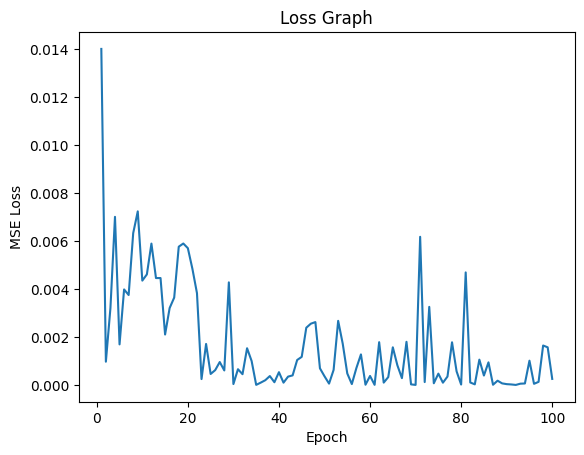

In [149]:
plt.plot(range(1,epochs+1),losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Graph')
plt.show();

## Forecasting into the future

In [150]:
forecast_horizon = 36 # Forecast horizon of upto 3 years
window_size = 12
predictions = y_norm[-window_size:].tolist()

model.eval() # Set model to evaluation mode

for i in range(forecast_horizon):
    sequence = torch.FloatTensor(predictions[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        predictions.append(model(sequence).item())

In [153]:
predictions[-forecast_horizon:]

[0.5388336181640625,
 0.5242959260940552,
 0.33597463369369507,
 0.307367742061615,
 0.4036385416984558,
 0.5507656335830688,
 0.3945276439189911,
 0.3886033892631531,
 0.46602025628089905,
 0.287442684173584,
 0.1807820200920105,
 0.36760538816452026,
 0.6620429754257202,
 0.6306744813919067,
 0.5164191126823425,
 0.3752475678920746,
 0.34359923005104065,
 0.4258401691913605,
 0.4497509300708771,
 0.40850284695625305,
 0.4478297531604767,
 0.26945415139198303,
 0.13911429047584534,
 0.23620517551898956,
 0.5284783840179443,
 0.873772144317627,
 0.5425211191177368,
 0.3880094587802887,
 0.38404783606529236,
 0.4448164403438568,
 0.3974711298942566,
 0.35410499572753906,
 0.47167399525642395,
 0.34816837310791016,
 0.18864266574382782,
 0.1621938943862915]

In [154]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions[-forecast_horizon:]

array([[15561.31599066],
       [15483.22455667],
       [14471.62796323],
       [14317.96167433],
       [14835.09498262],
       [15625.41063443],
       [14786.15440326],
       [14754.33136428],
       [15170.18789304],
       [14210.93118178],
       [13637.98712929],
       [14641.53739335],
       [16223.15387684],
       [16054.65321873],
       [15440.91305003],
       [14682.58852931],
       [14512.58464743],
       [14954.35441662],
       [15082.79472171],
       [14861.22434147],
       [15072.47482642],
       [14114.3030297 ],
       [13414.16255375],
       [13935.70107609],
       [15505.69126839],
       [17360.48945506],
       [15581.1239654 ],
       [14751.14097595],
       [14729.86051429],
       [15056.28835626],
       [14801.96578787],
       [14569.01797281],
       [15200.55781571],
       [14537.12849743],
       [13680.21178834],
       [13538.13817221]])

In [155]:
df.index

DatetimeIndex(['2003-03-01', '2003-04-01', '2003-05-01', '2003-06-01',
               '2003-07-01', '2003-08-01', '2003-09-01', '2003-10-01',
               '2003-11-01', '2003-12-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', name='date', length=142, freq='MS')

In [159]:
x = pd.date_range(start='2015-01-01',end='2017-12-01',freq='MS')
x

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [160]:
len(x)

36

## Visualizing forecast performance

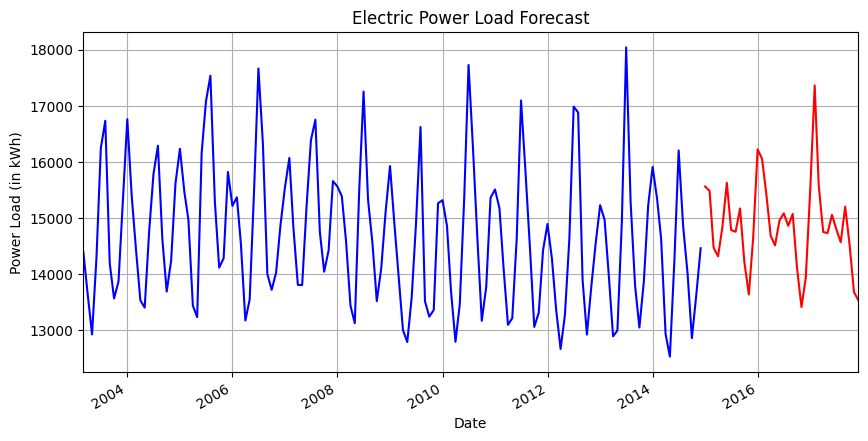

In [172]:
fig = plt.figure(figsize=(10,5))
plt.title('Electric Power Load Forecast')
plt.ylabel('Power Load (in kWh)')
plt.xlabel('Date')
plt.grid(visible=True)
plt.autoscale(enable=True,axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['demand'],'b')
plt.plot(x,true_predictions[-forecast_horizon:],'r')
plt.show()

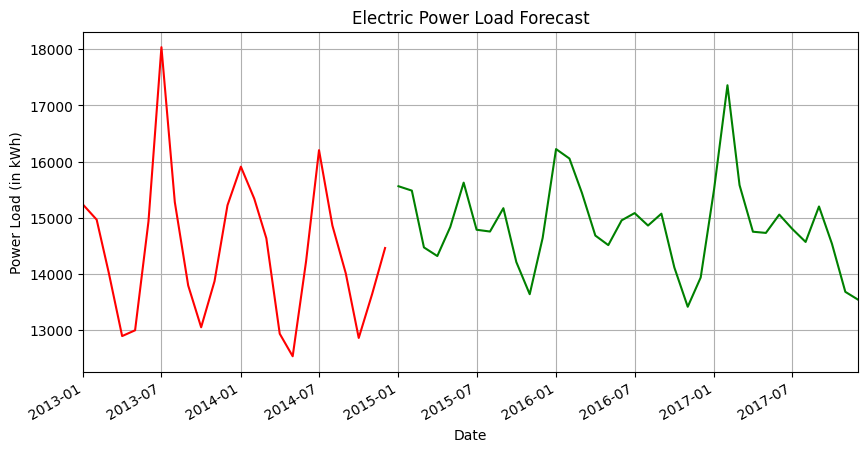

In [169]:
fig = plt.figure(figsize=(10,5))
plt.title('Electric Power Load Forecast')
plt.ylabel('Power Load (in kWh)')
plt.xlabel('Date')
plt.grid(visible=True)
plt.autoscale(enable=True,axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['demand']['2013-01-01':],'r')
plt.plot(x,true_predictions[-forecast_horizon:],'g')
plt.show()

## Saving the model for future use

In [173]:
torch.save(model,'electric_power_load_forecaster.pt')